# Full analysis of outbreak sample "1_japan" (From a sapovirus outbreak in miyagi
### Primary mapping : Mapping of reads gains reference US nashville strain and generation of consensus + variant call was done

We will use paired reads from one sample. These were collected during a sapovirus outbreak in 2009 
Let's start by aligning these reads to reference. The first step is creating an index to align the reads to. 

In [3]:
import os
os.chdir("/media/viro102/HD-ADU3/kte-data/sapo-ivar/test/outbreak_samples/GI.1/1_japan_bis/")

In [5]:
%%bash
bwa index MG012437_GI.1_ref.fa
echo "reference indexed"

reference indexed


[bwa_index] Pack FASTA... 0.00 sec
[bwa_index] Construct BWT for the packed sequence...
[bwa_index] 0.00 seconds elapse.
[bwa_index] Update BWT... 0.00 sec
[bwa_index] Pack forward-only FASTA... 0.00 sec
[bwa_index] Construct SA from BWT and Occ... 0.00 sec
[main] Version: 0.7.12-r1039
[main] CMD: bwa index MG012437_GI.1_ref.fa
[main] Real time: 0.061 sec; CPU: 0.009 sec


map reads to reference

In [8]:
%%bash
bwa mem -t 32  MG012437_GI.1_ref.fa  1_S1_L001_R1_001.fastq.gz 1_S1_L001_R2_001.fastq.gz | samtools view -b -F 4 -F 2048 | samtools sort -o 1_japan_GI.1_a.sorted.bam
tput setaf 1 echo "mapping completed"

[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 1472222 sequences (202392323 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (101, 627576, 207, 116)
[M::mem_pestat] analyzing insert size distribution for orientation FF...
[M::mem_pestat] (25, 50, 75) percentile: (693, 1441, 2861)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 7197)
[M::mem_pestat] mean and std.dev: (1789.65, 1488.75)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 9365)
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (77, 116, 171)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 359)
[M::mem_pestat] mean and std.dev: (128.99, 67.69)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 453)
[M::mem_pestat] analyzing insert size distribution for orientation RF...
[M::mem_pestat] (25, 50, 75) percentile: (44, 244, 1861)
[M::mem_pestat] low 

Let's now trim off the primer sequences using ivar. In order to do this we need three files.BED file with primer coordinates. We will generate this by aligning the primer sequences to the reference sequence and then using bedtools to create the BED file. Aligned and sorted BAM file generate in the previous step.

In [9]:
%%bash
bwa mem -k 5 -T 16 MG012437_GI.1_ref.fa Primalprimers_SaVGI.1_batch2_ok.fa  | samtools view -b -F 4 > Primalprimers_SaVGI.1_batch2_ok.fa.bam
bedtools bamtobed -i Primalprimers_SaVGI.1_batch2_ok.fa.bam > 1_japan_GI.1_primers.bed
tput setaf 1 echo "bed file with primers locations on ref generated"

[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 68 sequences (1520 bp)...
[M::mem_process_seqs] Processed 68 reads in 0.016 CPU sec, 0.015 real sec
[main] Version: 0.7.12-r1039
[main] CMD: bwa mem -k 5 -T 16 MG012437_GI.1_ref.fa Primalprimers_SaVGI.1_batch2_ok.fa
[main] Real time: 0.018 sec; CPU: 0.019 sec


We will now use BED file into ivar to trim primer sequences
Note that this BED file has to be generated only once per reference sequence.

In [12]:
%%bash
ivar trim -b 1_japan_GI.1_primers.bed -p 1_japan_GI.1.trimmed -i 1_japan_GI.1_a.sorted.bam
echo "primers trimming complete"

Number of references: 1
Reference Name: MG012437.1
Reference Length: 7388
Using Region: MG012437.1
Sorted By Coordinate
Sorted By Query Name
Processed 1000000 reads ... 
Results: 
Trimmed primers from 322874 reads.
66806 reads were shortened below the minimum length of 30 bp and were not writen to file.
910757 reads that started outside of primer regions were not written to file.


[E::idx_find_and_load] Could not retrieve index file for '1_japan_GI.1_a.sorted.bam'


let us sort and index trimmed BAM file.


In [13]:
%%bash
samtools sort -o 1_japan_GI.1.trimmed.sorted.bam 1_japan_GI.1.trimmed.bam ; samtools index 1_japan_GI.1.trimmed.sorted.bam
echo "trimmed BAM file Sorted and indexed"

Sorted and indexed trimmed BAM file


In [ ]:
#Let's quicky take a look at the depth of the trimmed vs untrimmed BAM file. We'll extract the depth using the samtools depth command.


In [14]:
%%bash
mkdir depth
samtools depth -a 1_japan_GI.1.trimmed.sorted.bam > depth/1_japan_GI.1.trimmed.sorted.bam.depth ; samtools depth -a 1_japan_GI.1_a.sorted.bam > depth/1_japan_GI.1.sorted.bam.depth
echo "please plot the depth per position"

please plot the depth per position


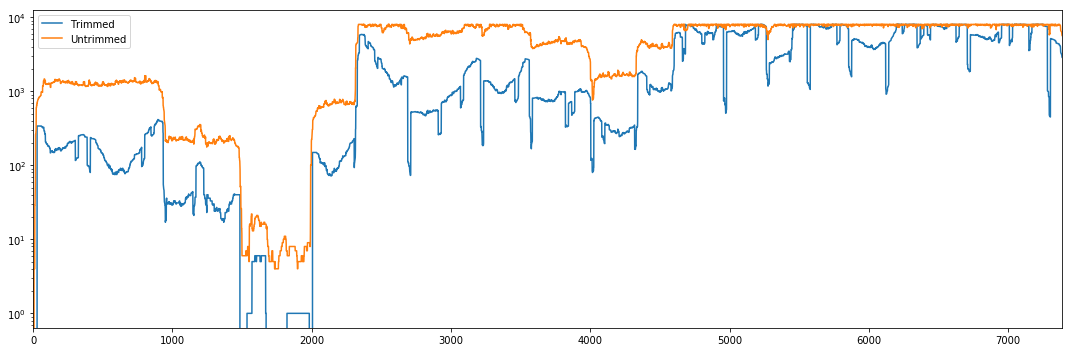

In [17]:
import os
os.chdir("/media/viro102/HD-ADU3/kte-data/sapo-ivar/test/outbreak_samples/GI.1/1_japan_bis/depth")
import pandas as pd 
import matplotlib.pyplot as plt
df_trimmed = pd.read_csv("1_japan_GI.1.trimmed.sorted.bam.depth", sep = "\t", names = ["Ref", "Pos","depth_tr"])
df_untrimmed = pd.read_csv("1_japan_GI.1.sorted.bam.depth", sep = "\t", names = ["Ref", "Pos","depth_untr"])
ax = df_trimmed["depth_tr"].plot(logy=True, label = "Trimmed", figsize = (15,5))
df_untrimmed["depth_untr"].plot(logy=True, ax = ax, label ="Untrimmed")
plt.legend()
plt.tight_layout()
plt.show()

Now, we need to identify primer sequences that might have a mismatch with the consensus sequence to ensure that we remove reads from any amplicon that might bias the iSNV frequency due to varying primer binding effeciency"
To do this, we should : 
-Call consensus on merged BAM file.
-align primer sequences to consensus after creating a bwa index from the consensus sequence called.

In [ ]:
%%bash
samtools mpileup -A -d 0 -Q 0 1_japan_GI.1.trimmed.sorted.bam  | ivar consensus -p 1_japan_GI.1.consensus   # call the consensus seq
echo "consensus called on merged BAM file."
bwa index -p 1_japan_GI.1.consensus 1_japan_GI.1.consensus.fa  # index consensus sequence
bwa mem -k 5 -T 16 1_japan_GI.1.consensus Primalprimers_SaVGI.1_batch2_ok.fa  | samtools view -bS -F 4 | samtools sort -o 1_japan_GI.1_primers_consensus.bam  # map primers to consensus

Let's now call iSNVs on this BAM file at a minimum threshold of 3% and the default minimum quality threshold of 20

In [ ]:
%%bash
samtools mpileup -A -d 0 --reference 1_japan_GI.1.consensus.fa -Q 0 1_japan_GI.1_primers_consensus.bam | ivar variants -p 1_japan_GI.1_primers_consensus_1 -t 0.03

Echo "Let's now get the indices of primers with mismtaches and their respective pairs. To get the pair information, we need a tsv file with two columns to represent the pairs of primers. This file is in pair_information.tsv"

In [22]:
%%bash
bedtools bamtobed -i 1_japan_GI.1_primers_consensus.bam > 1_japan_GI.1_primers_consensus.bam.bed ; ivar getmasked -i 1_japan_GI.1_primers_consensus_1.tsv -b 1_japan_GI.1_primers_consensus.bam.bed -f Primal-primers_SaVGI.1pairs_ok.tsv -p primer_mismatchers_indices
echo "you got the indices of primers with mismtaches and their respective pairs"

Primer pair for KTESAVG11_2_LEFT not found in BED file.
Primer pair for KTESAVG11_4_LEFT not found in BED file.
Primer pair for KTESAVG11_5_LEFT not found in BED file.
Primer pair for KTESAVG11_9_LEFT not found in BED file.
Primer pair for KTESAVG11_11_RIGHT not found in BED file.
Primer pair for KTESAVG11_12_RIGHT not found in BED file.
Primer pair for KTESAVG11_13_RIGHT not found in BED file.
Primer pair for KTESAVG11_14_RIGHT not found in BED file.
Primer pair for KTESAVG11_15_RIGHT not found in BED file.
Primer pair for KTESAVG11_16_RIGHT not found in BED file.
Primer pair for KTESAVG11_17_RIGHT not found in BED file.
Primer pair for KTESAVG11_18_RIGHT not found in BED file.
Primer pair for KTESAVG11_19_RIGHT not found in BED file.
Primer pair for KTESAVG11_20_RIGHT not found in BED file.
Primer pair for KTESAVG11_21_RIGHT not found in BED file.
Primer pair for KTESAVG11_22_RIGHT not found in BED file.
Primer pair for KTESAVG11_24_RIGHT not found in BED file.
Primer pair for KTESAV

let us remove reads from mismatched primers(Masking). Those reads are associated with false iSNPs. After that, let us compute depth in masked and unmasked files

In [24]:
%%bash
ivar removereads -i 1_japan_GI.1.trimmed.sorted.bam -p 1_japan_GI.1.bad_are_masked.bam -t primer_mismatchers_indices.txt -b 1_japan_GI.1_primers.bed
samtools sort -o 1_japan_GI.1.bad_are_masked.sorted.bam 1_japan_GI.1.bad_are_masked.bam 
samtools depth -a 1_japan_GI.1.bad_are_masked.sorted.bam > depth/1_japan_GI.1.bad_are_masked.sorted.depth


Writing to 1_japan_GI.1.bad_are_masked.bam
Number of references: 1
Reference Name: MG012437.1
Reference Length: 7388
Using Region: MG012437.1
Sorted By Coordinate
Results:
57569 reads were removed.


Let us now plot depth for the masked and unmasked samples

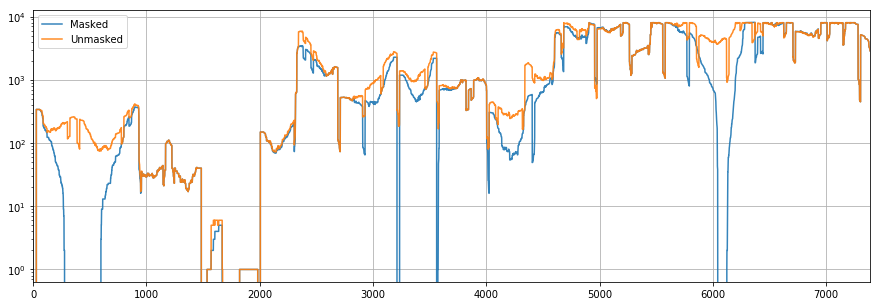

In [143]:
os.chdir("/media/viro102/HD-ADU3/kte-data/sapo-ivar/test/outbreak_samples/GI.1/1_japan_bis/depth")

import pandas as pd
import matplotlib.pyplot as plt
df_unmasked = pd.read_csv("1_japan_GI.1.trimmed.sorted.bam.depth", sep = "\t", names = ["Ref", "Pos", "depth_unmask"])
df_masked = pd.read_csv("1_japan_GI.1.bad_are_masked.sorted.depth", sep = "\t", names = ["Ref", "Pos", "depth_mask"])

ax = df_masked["depth_mask"].plot(logy=True, label = "Masked", figsize = (15,5), alpha = 0.9)
df_unmasked["depth_unmask"].plot(logy=True, ax = ax, label ="Unmasked", alpha=0.9)
plt.legend()
plt.grid()
plt.show()

Let's now call iSNVs from the BAMS without reads from the masked amplicons as well as the amino acid consequence of each mutation

In [137]:
os.chdir("/media/viro102/HD-ADU3/kte-data/sapo-ivar/test/outbreak_samples/GI.1/1_japan_bis/")

In [32]:
%%bash
samtools mpileup -A -d 0 --reference MG012437_GI.1_ref.fa -Q 0 1_japan_GI.1.bad_are_masked.sorted.bam | ivar variants -p 1_japan_GI.1_final -r MG012437_GI.1_ref.fa -g MG012437_GI.1.gff -t 0.03 ; echo "analysis is completed"
echo "please exclude variants at positions where depth <400 and count iSNV"

analysis is completed
please exclude variants with depth <400 and count iSNV


[mpileup] 1 samples in 1 input files
[mpileup] Max depth set to maximum value (2147483647)


show position of called variants

In [140]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
rep_a = pd.read_csv("1_japan_GI.1_final.tsv", sep="\t")
rep_a["S_NS"] = np.where(rep_a["REF_AA"] == rep_a["ALT_AA"], "S", "NS")
rep_a.head()

,REGION,POS,REF,ALT,REF_DP,REF_RV,REF_QUAL,ALT_DP,ALT_RV,ALT_QUAL,ALT_FREQ,TOTAL_DP,PVAL,PASS,GFF_FEATURE,REF_CODON,REF_AA,ALT_CODON,ALT_AA,S_NS
0,MG012437.1,46,C,T,0,0,0,336,0,38,1.000000,336,4.165050e-202,True,NaN,ACC,T,ACT,T,S
1,MG012437.1,49,T,C,0,0,0,338,0,38,1.000000,338,1.039720e-202,True,NaN,TTT,F,TTC,F,S
2,MG012437.1,97,A,G,3,0,36,167,0,37,0.982353,170,1.173180e-96,True,NaN,GAA,E,GAG,E,S
3,MG012437.1,106,C,T,0,0,0,157,0,38,1.000000,157,3.340400e-94,True,NaN,TGC,C,TGT,C,S
4,MG012437.1,125,C,T,2,0,36,120,0,38,0.983607,122,5.286610e-69,True,NaN,CAA,Q,TAA,*,NS


In [141]:
rep_b=rep_a[rep_a['TOTAL_DP'] >= 400]
shape = rep_b.shape 
shape # number of iSNVs is 193

(194, 20)

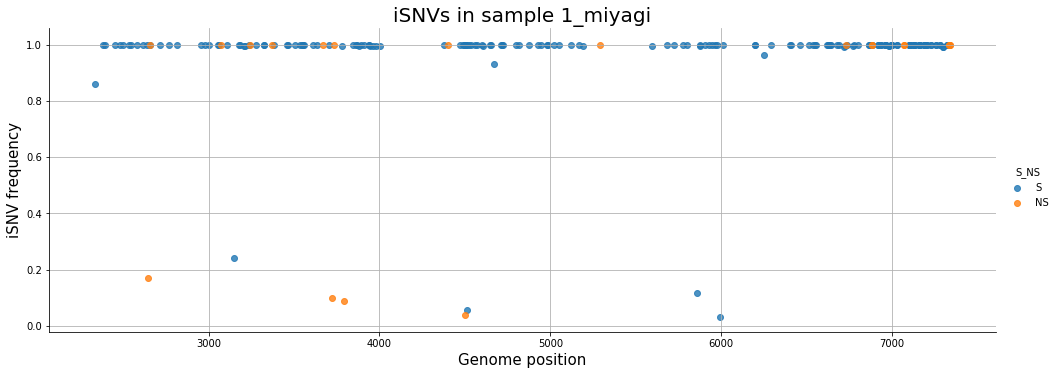

In [132]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
rep_b=rep_a[rep_a['TOTAL_DP'] >= 400]
sns.lmplot( x="POS", y="ALT_FREQ", data=rep_b, fit_reg=False, hue='S_NS',aspect=14/5, 
           legend=True, legend_out=True)
plt.xlabel('Genome position', fontsize=15)
plt.ylabel('iSNV frequency', fontsize=15)
plt.title('iSNVs in sample 1_miyagi', fontsize=20)
plt.grid(axis="both")
plt.show()

In [111]:
# let us filter snps in non structural region [1-5099]
print("snps in non structural region")
print((rep_b[(rep_b['POS'] > 3610) & (rep_b['POS'] < 5099)]).shape)
# let us filter snps in complete capsid[5010-6800]
print("snps in capsid")
print((rep_b[(rep_b['POS'] > 5100) & (rep_b['POS'] < 7350)]).shape)

snps in non structural region
(51, 20)
snps in capsid
(100, 20)


In [114]:
# what percentage of this masked genome (without reads from mismached primers) has depth >400 ? 
os.chdir("/media/viro102/HD-ADU3/kte-data/sapo-ivar/test/outbreak_samples/GI.1/1_japan_bis/depth")
df_masked = pd.read_csv("1_japan_GI.1.bad_are_masked.sorted.depth", sep = "\t", names = ["Ref", "Pos", "depth_mask"])
df_masked['400cov'] = np.where(df_masked['depth_mask']>=400, 'yes', 'no')
df_masked['100cov'] = np.where(df_masked['depth_mask']>=100, 'yes', 'no')
df_masked.head()

,Ref,Pos,depth_mask,400cov,100cov
0,MG012437.1,1,0,no,no
1,MG012437.1,2,0,no,no
2,MG012437.1,3,0,no,no
3,MG012437.1,4,0,no,no
4,MG012437.1,5,0,no,no


In [115]:
# What proportion of the genome is has a depth of coverage of at least >100 reads, >400 (Breadth ofcoverage)
my_tab1 = pd.crosstab(index=df_masked["100cov"],  # Make a crosstab
                              columns="Breadth 100coverage")      # Name the count column
my_tab2 = pd.crosstab(index=df_masked["400cov"],  # Make a crosstab
                              columns="Beadth above 400coverage")      # Name the count column
shape=df_masked.shape
print(shape)
print(my_tab1); print(my_tab2)

(7388, 5)
col_0   Breadth 100coverage
100cov                     
no                     2182
yes                    5206
col_0   Beadth above 400coverage
400cov                          
no                          2970
yes                         4418


In [118]:
4418/7388 * 100 # proportion of genome covered >400

59.799675148890095

In [119]:
5206/7388 * 100 # proportion of genome covered >100

70.4656199242014